# Supplementary Code

## Figure 2

/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_67024/3778330662.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


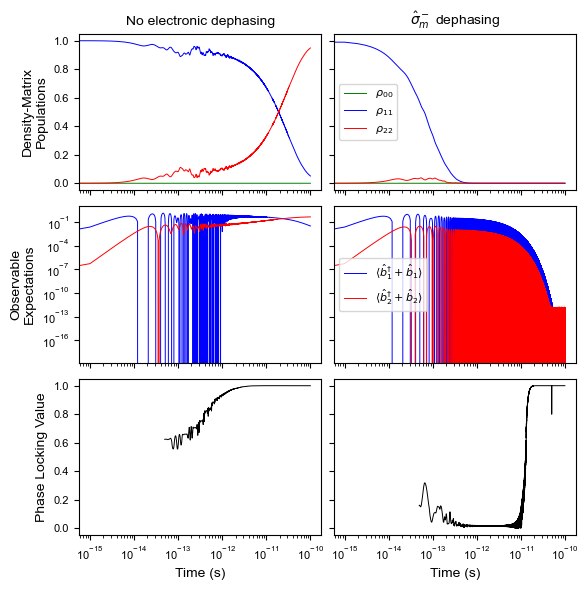

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.constants as cons
from scipy.signal import hilbert
from scipy.integrate import solve_ivp

# ---- Global plot style (Arial, label/tick fontsize=10, legend fontsize=8) ----
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 10,          # default text size
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

N = 3  # number of vibrational fock states
hbar = cons.hbar
kB = cons.k
h = cons.h
c = cons.c
ratio = h * c * 100

T = 298  # temperature
beta = 1/(kB * T)
J = 92 * ratio / hbar  # dipole-dipole interaction strength
w1, w2 = 1450 * ratio / hbar, 1111 * ratio / hbar  # vibrational energy quantum
S1, S2 = 0.1013, 0.0578
g1, g2 = -w1 * np.sqrt(S1), -w2 * np.sqrt(S2)  # coupling strength between electronic-vibrational states
De = 1042 * ratio / hbar

Gamma_th = 1e12  # Brownian dissipation rate
Gamma_deph = 1e13  # electronic dephasing rate

# Thermal average bath occupation
def n_ph(w, beta):
    return 1/(np.exp(beta*w)-1)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(6, 6), sharex=True, sharey='row')

colors = ['b', 'r', 'g']

psi0 = qt.tensor(qt.fock(N, 1), qt.basis(2, 0), qt.fock(N, 0), qt.basis(2, 1))
dm0 = psi0 * psi0.dag()

# Collapse operators
b1 = qt.tensor(qt.destroy(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))
sm1 = qt.tensor(qt.qeye(N), qt.sigmam(), qt.qeye(N), qt.qeye(2))
sx1 = qt.tensor(qt.qeye(N), qt.sigmax(), qt.qeye(N), qt.qeye(2))
sz1 = qt.tensor(qt.qeye(N), qt.sigmaz(), qt.qeye(N), qt.qeye(2))

b2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.destroy(N), qt.qeye(2))
sm2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmam())
sx2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmax())
sz2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmaz())

I = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))

op1 = sm1.dag() * sm1 * (I - sm2.dag() * sm2)
op2 = (I - sm1.dag() * sm1) * sm2.dag() * sm2

Hel = De/2 * (sm1.dag()*sm1 - sm2.dag()*sm2)
Hvib = w1 * b1.dag() * b1 + w2 * b2.dag() * b2
Vdip = J * (sm1.dag() * sm2 + sm2.dag() * sm1)
Vdis = g1 * op1 * (b1 + b1.dag()) + g2 * op2 * (b2 + b2.dag())
H = Hel + Hvib + Vdis + Vdip

c_op_list = []
# Vibron annihilation
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w1, beta))) * b1)
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w2, beta))) * b2)
# Vibron creation
c_op_list.append(np.sqrt(Gamma_th * n_ph(w1, beta)) * b1.dag())
c_op_list.append(np.sqrt(Gamma_th * n_ph(w2, beta)) * b2.dag())

e_op_list = []
e_op_list.append(b1 + b1.dag())
e_op_list.append(b2 + b2.dag())

t_end, t_len = 1e-10, int(1e5)
resol = 1e-13
dt = int(t_len/(t_end/resol))

tlist = np.linspace(0, t_end, t_len+1)
output = qt.mesolve(H, dm0, tlist, c_op_list, e_op_list, options={'store_states': True})

# Set all x-axes to log scale
for i in range(3):
    for j in range(2):
        ax[i, j].set_xscale("log")

ax[1, 0].set_yscale("log")

rho_11 = []
rho_22 = []
rho_00 = []
for state in output.states:
    rho = state.ptrace([1, 3]).full()
    rho_11.append(rho[1, 1])  # Population of the excited state for system 1
    rho_22.append(rho[2, 2])  # Population of the excited state for system 2
    rho_00.append(rho[0, 0])

ax[0, 0].plot(tlist, rho_00, c=colors[2], label=r"$\rho_{00}$", lw=0.7)
ax[0, 0].plot(tlist, rho_11, c=colors[0], label=r"$\rho_{11}$", lw=0.7)
ax[0, 0].plot(tlist, rho_22, c=colors[1], label=r"$\rho_{22}$", lw=0.7)

ax[1, 0].plot(tlist, np.real(output.expect[0]), c=colors[0], label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$", lw=0.7)
ax[1, 0].plot(tlist, np.real(output.expect[1]), c=colors[1], label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$", lw=0.7)

x1 = np.real(output.expect[0])
x2 = np.real(output.expect[1])

z1 = hilbert(x1)
z2 = hilbert(x2)

phi1 = np.angle(z1)
phi2 = np.angle(z2)

exp_phase = np.exp(1j * (phi1 - phi2))
PLV = np.abs(np.convolve(exp_phase, np.ones(dt)/dt, mode='valid'))

# time axis consistent with 'valid' convolution
t_plv = np.convolve(tlist, np.ones(dt)/dt, mode='valid')

ax[2, 0].plot(t_plv[:-dt], PLV[:-dt], c='k', lw=0.7)

# Excitation annihilation
c_op_list.append(np.sqrt(Gamma_deph) * sm1)
c_op_list.append(np.sqrt(Gamma_deph) * sm2)

output = qt.mesolve(H, dm0, tlist, c_op_list, e_op_list, options={'store_states': True})

rho_11 = []
rho_22 = []
rho_00 = []
for state in output.states:
    rho = state.ptrace([1, 3]).full()
    rho_11.append(rho[1, 1])  # Population of the excited state for system 1
    rho_22.append(rho[2, 2])  # Population of the excited state for system 2
    rho_00.append(rho[0, 0])

ax[0, 1].plot(tlist, rho_00, c=colors[2], label=r"$\rho_{00}$", lw=0.7)
ax[0, 1].plot(tlist, rho_11, c=colors[0], label=r"$\rho_{11}$", lw=0.7)
ax[0, 1].plot(tlist, rho_22, c=colors[1], label=r"$\rho_{22}$", lw=0.7)

ax[1, 1].plot(tlist, np.real(output.expect[0]), c=colors[0], label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$", lw=0.7)
ax[1, 1].plot(tlist, np.real(output.expect[1]), c=colors[1], label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$", lw=0.7)

x1 = np.real(output.expect[0])
x2 = np.real(output.expect[1])

z1 = hilbert(x1)
z2 = hilbert(x2)

phi1 = np.angle(z1)
phi2 = np.angle(z2)

exp_phase = np.exp(1j * (phi1 - phi2))
PLV = np.abs(np.convolve(exp_phase, np.ones(dt)/dt, mode='valid'))
# time axis consistent with 'valid' convolution
t_plv = np.convolve(tlist, np.ones(dt)/dt, mode='valid')


ax[2, 1].plot(t_plv[:-dt], PLV[:-dt], c='k', lw=0.7)

ax[0, 0].set_title("No electronic dephasing")
ax[0, 1].set_title(r"$\hat{\sigma}^-_m$ dephasing")

ax[2, 0].set_xlabel("Time (s)")
ax[2, 1].set_xlabel("Time (s)")

ax[0, 0].set_ylabel("Density-Matrix\nPopulations")
ax[1, 0].set_ylabel("Observable\nExpectations")
ax[2, 0].set_ylabel("Phase Locking Value")

# Legends with explicit Arial font specification
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(family='Arial', size=8)

for i in range(2):
    ax[i, 1].legend(loc="center left", prop=font_prop)

# Hide x-tick labels for rows 0 and 1
for i in range(2):  # rows 0 and 1
    for j in range(2):  # both columns
        ax[i, j].tick_params(labelbottom=False)  # Change this line

# Ensure all tick labels and axes labels apply the intended font settings robustly
for a in ax.ravel():
    a.tick_params(axis='both', which='both', labelsize=8)
    for lbl in (a.get_xticklabels() + a.get_yticklabels()):
        lbl.set_fontname("Arial")
    a.xaxis.label.set_fontname("Arial")
    a.yaxis.label.set_fontname("Arial")
    a.title.set_fontname("Arial")
    leg = a.get_legend()
    if leg is not None:
        for text in leg.get_texts():
            text.set_fontname("Arial")

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.05)

# Save the figure
plt.savefig("/Users/wenhao/Documents/Wenhao_Files/Exeter/Photo-synthesis/Photosynthesis_REUSE/complete_0_logy_logx.pdf", dpi=600, bbox_inches='tight')
plt.show()

## Figure 3

/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_59131/1833191769.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


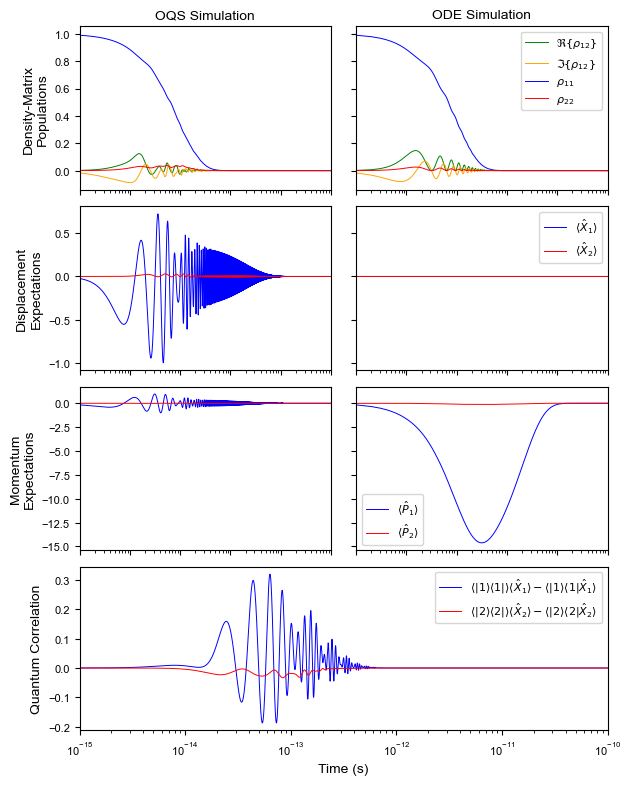

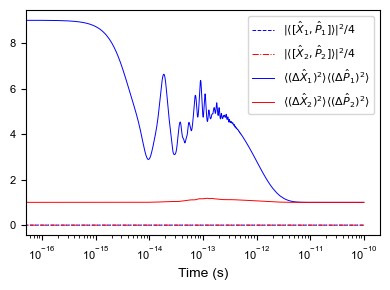

In [38]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.constants as cons
from scipy.signal import hilbert
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec

# ---- Global plot style (Arial, label fontsize=10, legend/tick fontsize=8) ----
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

N = 3  # number of vibrational fock states
hbar = cons.hbar
kB = cons.k
h = cons.h
c = cons.c
ratio = h * c * 100

T = 298 # temperature
beta = 1/(kB * T)
J = 92 * ratio / hbar # dipole-dipole interaction strength
w1, w2 = 1450 * ratio / hbar, 1111 * ratio / hbar # vibrational energy quantum
S1, S2 = 0.1013, 0.0578
g1, g2 = w1 * np.sqrt(S1), w2 * np.sqrt(S2) # coupling strength between electronic-vibrational states
De = 1042 * ratio / hbar

Gamma_th = 1e12 # Brownian dissipation rate
Gamma_deph = 1e13 # electronic dephasing rate
# thermal average bath occupation
def n_ph(w, beta):
    return 1/(np.exp(beta*w)-1)
#%%

# Create a figure
fig = plt.figure(figsize=(6, 8))

# Create a GridSpec with 4 rows and 2 columns
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], hspace=0.1, wspace=0.1)

# Create subplots in the GridSpec
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1], sharey=ax00)
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1], sharey=ax10)
ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1], sharey=ax20)
ax3 = fig.add_subplot(gs[3, :])

# Custom colors
colors = ['b', 'r', 'g', 'orange']

psi0 = qt.tensor(qt.fock(N, 1), qt.basis(2, 0), qt.fock(N, 0), qt.basis(2, 1))
dm0 = psi0 * psi0.dag()
# collapse operators
b1 = qt.tensor(qt.destroy(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))
sm1 = qt.tensor(qt.qeye(N), qt.sigmam(), qt.qeye(N), qt.qeye(2))
sx1 = qt.tensor(qt.qeye(N), qt.sigmax(), qt.qeye(N), qt.qeye(2))
sz1 = qt.tensor(qt.qeye(N), qt.sigmaz(), qt.qeye(N), qt.qeye(2))

b2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.destroy(N), qt.qeye(2))
sm2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmam())
sx2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmax())
sz2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmaz())

I = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))

op1 = sm1.dag() * sm1 * (I - sm2.dag() * sm2)
op2 = (I - sm1.dag() * sm1) * sm2.dag() * sm2

Hel = De/2 * (sm1.dag()*sm1 - sm2.dag()*sm2)
Hvib = w1 * b1.dag() * b1 + w2 * b2.dag() * b2
Vdip = J * (sm1.dag() * sm2 + sm2.dag() * sm1)
Vdis = g1 * op1 * (b1+b1.dag()) - g2 * op2 * (b2+b2.dag())
H = Hel + Hvib + Vdis + Vdip

c_op_list = []
# Vibron annihilation
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w1, beta))) * b1)
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w2, beta))) * b2)
# Vibron creation
c_op_list.append(np.sqrt(Gamma_th * n_ph(w1, beta)) * b1.dag())
c_op_list.append(np.sqrt(Gamma_th * n_ph(w2, beta)) * b2.dag())
# Excitation annihilation
c_op_list.append(np.sqrt(Gamma_deph) * sm1)
c_op_list.append(np.sqrt(Gamma_deph) * sm2)

e_op_list = []
e_op_list.append(b1 + b1.dag())
e_op_list.append(b2 + b2.dag())
e_op_list.append(1j*(b1.dag() - b1))
e_op_list.append(1j*(b2.dag() - b2))
e_op_list.append(op1)
e_op_list.append(op2)
e_op_list.append(sm1.dag() * sm2)
e_op_list.append(op1 * (b1 + b1.dag()))
e_op_list.append(op2 * (b2 + b2.dag()))
e_op_list.append((b1 + b1.dag()) * (b1 + b1.dag()))
e_op_list.append((b2 + b2.dag()) * (b2 + b2.dag()))
e_op_list.append(-(b1.dag() - b1) * (b1.dag() - b1))
e_op_list.append(-(b2.dag() - b2) * (b2.dag() - b2))
e_op_list.append((b1 + b1.dag()) * (b2 + b2.dag()) - (b2 + b2.dag()) * (b1 + b1.dag()))
e_op_list.append(1j*(b1.dag() - b1) * 1j*(b2.dag() - b2) - 1j*(b2.dag() - b2) * 1j*(b1.dag() - b1))

t_end, t_len = 1e-10, int(1e6)+1
resol = 1e-13
dt = int(t_len/(t_end/resol))

tlist = np.linspace(0, t_end, t_len)
output = qt.mesolve(H, dm0, tlist, c_op_list, e_op_list, options = {'store_states': False})

# # Extract the populations of the excited states
# rho_11 = []
# rho_22 = []
# rho_12r = []
# rho_12i = []

# for state in output.states:
#     rho = state.ptrace([1, 3]).full()
#     rho_11.append(rho[1, 1])  # Population of the excited state for system 1
#     rho_22.append(rho[2, 2])  # Population of the excited state for system 2
#     rho_12r.append(np.real(rho[1, 2]))
#     rho_12i.append(np.imag(rho[1, 2]))

# ax00.plot(tlist, rho_12r, c=colors[2], label=r"$\Re\{\rho_{12}\}$")
# ax00.plot(tlist, rho_12i, c=colors[3], label=r"$\Im\{\rho_{12}\}$")
# ax00.plot(tlist, rho_11, c=colors[0], label=r"$\rho_{11}$")
# ax00.plot(tlist, rho_22, c=colors[1], label=r"$\rho_{22}$")
ax00.plot(tlist, np.real(output.expect[6]), c=colors[2], label=r"$\Re\{\rho_{12}\}$", lw=0.7)
ax00.plot(tlist, np.imag(output.expect[6]), c=colors[3], label=r"$\Im\{\rho_{12}\}$", lw=0.7)
ax00.plot(tlist, output.expect[4], c=colors[0], label=r"$\rho_{11}$", lw=0.7)
ax00.plot(tlist, output.expect[5], c=colors[1], label=r"$\rho_{22}$", lw=0.7)
ax00.set_xscale("log")
ax00.set_ylabel('Density-Matrix\nPopulations')
ax00.set_xlim([1e-15, t_end])

ax10.plot(tlist, output.expect[0], c=colors[0], label=r"$\langle\hat{X}_1\rangle$", lw=0.7)
ax10.plot(tlist, output.expect[1], c=colors[1], label=r"$\langle\hat{X}_2\rangle$", lw=0.7)
ax10.set_xscale("log")
ax10.set_ylabel('Displacement\nExpectations')
ax10.set_xlim([1e-15, t_end])

ax20.plot(tlist, output.expect[2], c=colors[0], label=r"$\langle\hat{P}_1\rangle$", lw=0.7)
ax20.plot(tlist, output.expect[3], c=colors[1], label=r"$\langle\hat{P}_2\rangle$", lw=0.7)
ax20.set_xscale("log")
ax20.set_ylabel('Momentum\nExpectations')
ax20.set_xlim([1e-15, t_end])

#%%
# Define the system of ODEs
def system(t, y):
    x1, x2, x3, x4, x5, x6, x7, x8 = y

    dx1_dt = 2 * J * x4 - Gamma_deph * x1
    dx2_dt = -2 * J * x4 - Gamma_deph * x2
    dx3_dt = -(De + g1 * x5 - g2 * x6) * x4 - Gamma_deph * x3
    dx4_dt = (De + g1 * x5 - g2 * x6) * x3 - J * (x1 - x2) - Gamma_deph * x4
    dx5_dt = x7 - (Gamma_th / 2) * x5
    dx6_dt = x8 - (Gamma_th / 2) * x6
    dx7_dt = -x5 - (Gamma_th / 2) * x7 - 2 * g1 * x1
    dx8_dt = -x6 - (Gamma_th / 2) * x8 - 2 * g2 * x2

    return [dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt, dx6_dt, dx7_dt, dx8_dt]

# Initial conditions
initial_conditions = [1, 0, 0, 0, 0, 0, 0, 0]  # Example values

# Time span
t_span = (0, 1e-10)  # Example value for the time span
t_eval = np.linspace(*t_span, int(1e5)+1)  # Time points where the solution is computed

# Solve the ODEs
sol = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval)

ax01.plot(sol.t, sol.y[2], c=colors[2], label=r"$\Re\{\rho_{12}\}$", lw=0.7)
ax01.plot(sol.t, sol.y[3], c=colors[3], label=r"$\Im\{\rho_{12}\}$", lw=0.7)
ax01.plot(sol.t, sol.y[0], c=colors[0], label=r"$\rho_{11}$", lw=0.7)
ax01.plot(sol.t, sol.y[1], c=colors[1], label=r"$\rho_{22}$", lw=0.7)
ax01.set_xscale("log")
ax01.set_xlim([1e-15, t_end])

ax11.plot(sol.t, sol.y[4], c=colors[0], label=r"$\langle\hat{X}_1\rangle$", lw=0.7)
ax11.plot(sol.t, sol.y[5], c=colors[1], label=r"$\langle\hat{X}_2\rangle$", lw=0.7)
ax11.set_xscale("log")
ax11.set_xlim([1e-15, t_end])

ax21.plot(sol.t, sol.y[6], c=colors[0], label=r"$\langle\hat{P}_1\rangle$", lw=0.7)
ax21.plot(sol.t, sol.y[7], c=colors[1], label=r"$\langle\hat{P}_2\rangle$", lw=0.7)
ax21.set_xscale("log")
ax21.set_xlim([1e-15, t_end])

ops_diff1 = output.expect[0] * output.expect[4] - output.expect[7]
ops_diff2 = output.expect[1] * output.expect[5] - output.expect[8]
ax3.plot(tlist, ops_diff1, c=colors[0], label=r"$\langle |1\rangle\langle 1| \rangle\langle \hat{X}_1\rangle-\langle |1\rangle\langle 1| \hat{X}_1\rangle$", lw=0.7)
ax3.plot(tlist, ops_diff2, c=colors[1], label=r"$\langle |2\rangle\langle 2| \rangle\langle \hat{X}_2\rangle-\langle |2\rangle\langle 2| \hat{X}_2\rangle$", lw=0.7)
ax3.set_xscale("log")
ax3.set_ylabel('Quantum Correlation')
ax3.set_xlim([1e-15, t_end])

# Plot something in each subplot
for ax in [ax00, ax01, ax10, ax11, ax20, ax21]:
    ax.label_outer()  # Only show outer labels to avoid label cluttering
    ax.tick_params(labelbottom=False)  # Remove x labels

# Remove y labels for subplots in column 2 (rows 1 to 3)
for ax in [ax01, ax11, ax21]:
    ax.tick_params(labelleft=False)

ax3.set_xlabel("Time (s)")

ax00.set_title("OQS Simulation")
ax01.set_title("ODE Simulation")

# Add legends with explicit fontsize=8
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(family='Arial', size=8)

ax01.legend(prop=font_prop)
ax11.legend(prop=font_prop)
ax21.legend(prop=font_prop)
ax3.legend(prop=font_prop)

# Ensure all text elements use Arial font
for ax in [ax00, ax01, ax10, ax11, ax20, ax21, ax3]:
    for lbl in (ax.get_xticklabels() + ax.get_yticklabels()):
        lbl.set_fontname("Arial")
    ax.xaxis.label.set_fontname("Arial")
    ax.yaxis.label.set_fontname("Arial")
    ax.title.set_fontname("Arial")

plt.subplots_adjust(left=0.08, right=0.96, top=0.96, bottom=0.08)

# Save the figure
fig.savefig("complete_odevsops.pdf", dpi=600, bbox_inches="tight")
plt.show()

#%%
fig, ax = plt.subplots(figsize=(4,3))

dX1 = output.expect[9] - (output.expect[0])**2
dX2 = output.expect[10] - (output.expect[1])**2
dP1 = output.expect[11] - (output.expect[2])**2
dP2 = output.expect[12] - (output.expect[3])**2
RHS1 = np.abs(output.expect[13])**2/4
RHS2 = np.abs(output.expect[14])**2/4
ax.plot(tlist, RHS1, c=colors[0], ls="--", label=r"$|\langle[\hat{X}_1,\hat{P}_1]\rangle|^2/4$", lw=0.7)
ax.plot(tlist, RHS2, c=colors[1], ls="-.", label=r"$|\langle[\hat{X}_2,\hat{P}_2]\rangle|^2/4$", lw=0.7)
ax.plot(tlist, dX1*dP1, c=colors[0], label=r"$\langle(\Delta\hat{X}_1)^2\rangle\langle(\Delta\hat{P}_1)^2\rangle$", lw=0.7)
ax.plot(tlist, dX2*dP2, c=colors[1], label=r"$\langle(\Delta\hat{X}_2)^2\rangle\langle(\Delta\hat{P}_2)^2\rangle$", lw=0.7)

ax.set_xlabel("Time (s)")
ax.legend(loc="upper right", prop=font_prop)
ax.set_xscale("log")

# Ensure Arial font for second figure
for lbl in (ax.get_xticklabels() + ax.get_yticklabels()):
    lbl.set_fontname("Arial")
ax.xaxis.label.set_fontname("Arial")
ax.yaxis.label.set_fontname("Arial")

fig.tight_layout()
plt.show()

## Figure 4

/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/956500028.py:41: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/956500028.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


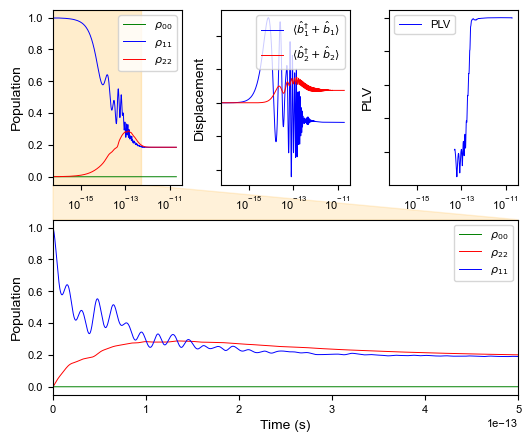

In [15]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.constants as cons
from scipy.signal import hilbert
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

# ---- Global plot style (Arial, label/tick fontsize=10, legend fontsize=8) ----
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

N = 3  # number of vibrational fock states
hbar = cons.hbar
kB = cons.k
h = cons.h
c = cons.c
ratio = h * c * 100

T = 298  # temperature
beta = 1/(kB * T)
J = 92 * ratio / hbar  # dipole-dipole interaction strength
w1, w2 = 1450 * ratio / hbar, 1111 * ratio / hbar  # vibrational energy quantum
S1, S2 = 0.1013, 0.0578
g1, g2 = -w1 * np.sqrt(S1), -w2 * np.sqrt(S2)  # coupling strength between electronic-vibrational states
De = 1042 * ratio / hbar

Gamma_th = 1e12  # Brownian dissipation rate
Gamma_deph = 1e13  # electronic dephasing rate
Gamma_p = 1e13 # envrionment-assisted transfer rate

# Thermal average bath occupation
def n_ph(w, beta):
    return 1/(np.exp(beta*w)-1)

fig = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 3, figure=fig, hspace=0.2, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
ax3 = fig.add_subplot(gs[0, 2], sharex=ax2)  # First row, third column
ax4 = fig.add_subplot(gs[1, 0:3])  # Second row, spanning all columns

# Define custom colors
color_green = 'g'
color_blue = 'b'
color_red = 'r'

psi0 = qt.tensor(qt.fock(N, 1), qt.basis(2, 0), qt.fock(N, 0), qt.basis(2, 1))
dm0 = psi0 * psi0.dag()

# Collapse operators
b1 = qt.tensor(qt.destroy(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))
sm1 = qt.tensor(qt.qeye(N), qt.sigmam(), qt.qeye(N), qt.qeye(2))
sx1 = qt.tensor(qt.qeye(N), qt.sigmax(), qt.qeye(N), qt.qeye(2))
sz1 = qt.tensor(qt.qeye(N), qt.sigmaz(), qt.qeye(N), qt.qeye(2))

b2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.destroy(N), qt.qeye(2))
sm2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmam())
sx2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmax())
sz2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmaz())

I = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))

op1 = sm1.dag() * sm1 * (I - sm2.dag() * sm2)
op2 = (I - sm1.dag() * sm1) * sm2.dag() * sm2

c_op_list = []
# Vibron annihilation
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w1, beta))) * b1)
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w2, beta))) * b2)
# Vibron creation
c_op_list.append(np.sqrt(Gamma_th * n_ph(w1, beta)) * b1.dag())
c_op_list.append(np.sqrt(Gamma_th * n_ph(w2, beta)) * b2.dag())
# Excitation annihilation
c_op_list.append(np.sqrt(Gamma_deph) * sm1)
c_op_list.append(np.sqrt(Gamma_deph) * sm2)

c_op_list.append(np.sqrt(Gamma_p) * sm2.dag()*sm1)

# Expectation operators
e_op_list = []
e_op_list.append(b1 + b1.dag())
e_op_list.append(b2 + b2.dag())

t_end, t_len = 2e-11, int(2e5)
resol = 1e-13
dt = int(t_len/(t_end/resol))

tlist = np.linspace(0, t_end, t_len+1)

e1, e2, ep = 19574 * ratio / hbar, 18532 * ratio / hbar, 60000 * ratio / hbar
wp = e1 + w1
Omega = 2e14

op0 = sm1.dag() * sm1 * sm2.dag() * sm2

Hel = e1 * op1 + e2 * op2 + ep * op0
Hvib = w1 * b1.dag() * b1 + w2 * b2.dag() * b2
Vdis = g1 * op1 * (b1 + b1.dag()) + g2 * op2 * (b2 + b2.dag())
Vdip = J * (sm1.dag() * sm2 + sm2.dag() * sm1)

H = Hel + Hvib + Vdis + Vdip
# Simulation arguments
args = {'wp': wp}
# Pumping interaction Hamiltonian (time-dependent part)
Vp_h = (Omega/2) * sm1.dag()

# Time-dependent coefficients for the pumping interaction
def Vp_h_coeff(t, args):
    return np.exp(-1j * args['wp'] * t)

def Vp_c_coeff(t, args):
    return np.exp(1j * args['wp'] * t)

# Time-dependent simulation
H_new = [H, [Vp_h, Vp_h_coeff], [Vp_h.dag(), Vp_c_coeff]]

output = qt.mesolve(H_new, dm0, tlist, c_op_list, e_op_list, args=args,
                    options={'store_states': True})

ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")

rho_11 = []
rho_22 = []
rho_00 = []
for state in output.states:
    rho = state.ptrace([1, 3]).full()
    rho_11.append(rho[1, 1])  # Population of the excited state for system 1
    rho_22.append(rho[2, 2])  # Population of the excited state for system 2
    rho_00.append(rho[0, 0])

# Plot ax1 with custom colors and linewidth
ax1.plot(tlist, rho_00, c=color_green, label=r"$\rho_{00}$", lw=0.7)
ax1.plot(tlist, rho_11, c=color_blue, label=r"$\rho_{11}$", lw=0.7)
ax1.plot(tlist, rho_22, c=color_red, label=r"$\rho_{22}$", lw=0.7)

# Add shaded zoom region on ax1
zoom_start, zoom_end = 0, 5e-13
ax1.axvspan(zoom_start, zoom_end, alpha=0.2, color='orange', zorder=0)

ax2.plot(tlist, output.expect[0], c=color_blue, label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$", lw=0.7)
ax2.plot(tlist, output.expect[1], c=color_red, label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$", lw=0.7)

# Fix: take real part before applying Hilbert transform
phi1 = np.angle(hilbert(np.real(output.expect[0])))
phi2 = np.angle(hilbert(np.real(output.expect[1])))
exp_phase = np.exp(1j * (phi1 - phi2))
# Initialize the moving average array
PLV = np.abs(np.convolve(exp_phase, np.ones(dt)/dt, mode='valid'))
t_plv = np.abs(np.convolve(tlist, np.ones(dt)/dt, mode='valid'))

ax3.plot(t_plv[:-dt], PLV[:-dt], label='PLV', lw=0.7, c=color_blue)

# Plot ax4 (zoom panel) with custom colors and linewidth
ax4.plot(tlist, rho_00, c=color_green, label=r"$\rho_{00}$", lw=0.7)
ax4.plot(tlist, rho_22, c=color_red, label=r"$\rho_{22}$", lw=0.7)
ax4.plot(tlist, rho_11, c=color_blue, label=r"$\rho_{11}$", lw=0.7)

ax4.set_xlim([0, 5e-13])
ax4.set_xlabel("Time (s)", fontsize=10)
ax1.set_ylabel("Population", fontsize=10)
ax2.set_ylabel("Displacement", fontsize=10)
ax3.set_ylabel("PLV", fontsize=10)
ax4.set_ylabel("Population", fontsize=10)

ax1.legend(fontsize=8, loc="best")
ax2.legend(fontsize=8, loc="best")
ax3.legend(fontsize=8, loc="best")
ax4.legend(fontsize=8, loc="best")

ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Enforce Arial font on all elements
for a in [ax1, ax2, ax3, ax4]:
    a.tick_params(axis='both', which='both', labelsize=8)
    for lbl in (a.get_xticklabels() + a.get_yticklabels()):
        lbl.set_fontname("Arial")
    a.xaxis.label.set_fontname("Arial")
    a.yaxis.label.set_fontname("Arial")
    if a.get_title():
        a.title.set_fontname("Arial")
    leg = a.get_legend()
    if leg is not None:
        for text in leg.get_texts():
            text.set_fontname("Arial")

plt.tight_layout()

# ========== ADD ZOOM POLYGON CONNECTING ax1 TO ax4 ==========
fig.canvas.draw()

try:
    # Get axis positions in figure coordinates
    bbox_ax1 = ax1.get_position()
    bbox_ax4 = ax4.get_position()
    
    # Define zoom region in ax1's x-axis (in data coordinates)
    x1_data = [zoom_start, zoom_end]
    
    # Get ax1's x-axis limits to calculate relative positions
    x1_lim = ax1.get_xlim()
    
    # Since ax1 is log scale, we need to work in log space
    x1_log_lim = [np.log10(x1_lim[0]), np.log10(x1_lim[1])]
    x1_log_data = [np.log10(x1_data[0]) if x1_data[0] > 0 else x1_log_lim[0], 
                   np.log10(x1_data[1])]
    
    # Calculate relative positions in the axis (0 to 1)
    x1_left_rel = (x1_log_data[0] - x1_log_lim[0]) / (x1_log_lim[1] - x1_log_lim[0])
    x1_right_rel = (x1_log_data[1] - x1_log_lim[0]) / (x1_log_lim[1] - x1_log_lim[0])
    
    # Clamp to valid range [0, 1]
    x1_left_rel = max(0, min(1, x1_left_rel))
    x1_right_rel = max(0, min(1, x1_right_rel))
    
    # Convert to figure coordinates
    x1_left_fig = bbox_ax1.x0 + x1_left_rel * bbox_ax1.width
    x1_right_fig = bbox_ax1.x0 + x1_right_rel * bbox_ax1.width
    
    # Bottom of ax1, top of ax4
    y1_bottom_fig = bbox_ax1.y0
    y4_top_fig = bbox_ax4.y1
    
    # Create polygon corners connecting from ax1 bottom to ax4 top
    zoom_polygon = Polygon([
        [x1_left_fig, y1_bottom_fig],      # Bottom-left of zoom region in ax1
        [x1_right_fig, y1_bottom_fig],     # Bottom-right of zoom region in ax1
        [bbox_ax4.x1, y4_top_fig],         # Top-right of ax4
        [bbox_ax4.x0, y4_top_fig]          # Top-left of ax4
    ],
    transform=fig.transFigure,
    facecolor='orange', edgecolor='orange',
    alpha=0.15, linewidth=1.0, zorder=-1, clip_on=False)
    fig.add_artist(zoom_polygon)
    
except Exception as e:
    print(f"Warning: Could not add zoom polygon: {e}")

# plt.savefig(
#     "electronic_population_new.pdf",
#     dpi=300,
#     bbox_inches='tight',
#     transparent=True
# )
plt.show()

If electronic dephasing is switched off, a more pronounced difference emerges between the open quantum dynamics and its semiclassical counterpart.

<ipython-input-11-fbe96b5c288e>:28: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


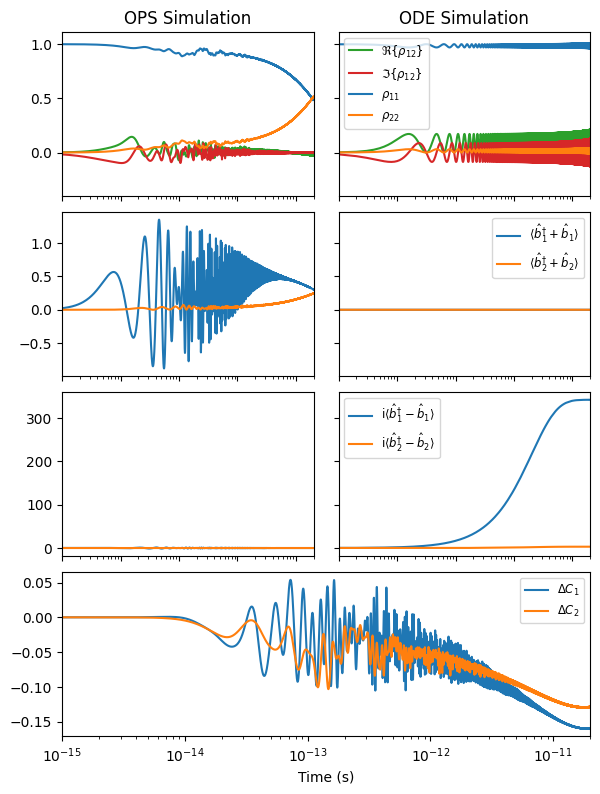

In [11]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.constants as cons
from scipy.signal import hilbert
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec

N = 3  # number of vibrational fock states
hbar = cons.hbar
kB = cons.k
h = cons.h
c = cons.c
ratio = h * c * 100

T = 298 # temperature
beta = 1/(kB * T)
J = 92 * ratio / hbar # dipole-dipole interaction strength
w1, w2 = 1450 * ratio / hbar, 1111 * ratio / hbar # vibrational energy quantum
S1, S2 = 0.1013, 0.0578
g1, g2 = -w1 * np.sqrt(S1), -w2 * np.sqrt(S2) # coupling strength between electronic-vibrational states
De = 1042 * ratio / hbar

Gamma_th = 1e12 # Brownian dissipation rate
Gamma_deph = 0 # electronic dephasing rate
# thermal average bath occupation
def n_ph(w, beta):
    return 1/(np.exp(beta*w)-1)
#%%

# Create a figure
fig = plt.figure(figsize=(6, 8))

# Create a GridSpec with 4 rows and 2 columns
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], hspace=0.1, wspace=0.1)

# Create subplots in the GridSpec
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1], sharey=ax00)
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1], sharey=ax10)
ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1], sharey=ax20)
ax3 = fig.add_subplot(gs[3, :])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

psi0 = qt.tensor(qt.fock(N, 1), qt.basis(2, 0), qt.fock(N, 0), qt.basis(2, 1))
dm0 = psi0 * psi0.dag()
# collapse operators
b1 = qt.tensor(qt.destroy(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))
sm1 = qt.tensor(qt.qeye(N), qt.sigmam(), qt.qeye(N), qt.qeye(2))
sx1 = qt.tensor(qt.qeye(N), qt.sigmax(), qt.qeye(N), qt.qeye(2))
sz1 = qt.tensor(qt.qeye(N), qt.sigmaz(), qt.qeye(N), qt.qeye(2))

b2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.destroy(N), qt.qeye(2))
sm2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmam())
sx2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmax())
sz2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmaz())

I = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))

op1 = sm1.dag() * sm1 * (I - sm2.dag() * sm2)
op2 = (I - sm1.dag() * sm1) * sm2.dag() * sm2

Hel = De/2 * (sm1.dag()*sm1 - sm2.dag()*sm2)
Hvib = w1 * b1.dag() * b1 + w2 * b2.dag() * b2
Vdip = J * (sm1.dag() * sm2 + sm2.dag() * sm1)
Vdis = g1 * op1 * (b1 + b1.dag()) + g2 * op2 * (b2 + b2.dag())
H = Hel + Hvib + Vdis + Vdip

c_op_list = []
# Vibron annihilation
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w1, beta))) * b1)
c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w2, beta))) * b2)
# Vibron creation
c_op_list.append(np.sqrt(Gamma_th * n_ph(w1, beta)) * b1.dag())
c_op_list.append(np.sqrt(Gamma_th * n_ph(w2, beta)) * b2.dag())
# Excitation annihilation
c_op_list.append(np.sqrt(Gamma_deph) * sm1)
c_op_list.append(np.sqrt(Gamma_deph) * sm2)

e_op_list = []
e_op_list.append(b1 + b1.dag())
e_op_list.append(b2 + b2.dag())
e_op_list.append(1j*(b1.dag() - b1))
e_op_list.append(1j*(b2.dag() - b2))
e_op_list.append(op1)
e_op_list.append(op2)
e_op_list.append(sm1.dag() * sm2)
e_op_list.append(op1 * (b1 + b1.dag()))
e_op_list.append(op2 * (b2 + b2.dag()))
e_op_list.append((b1 + b1.dag()) * (b1 + b1.dag()))
e_op_list.append((b2 + b2.dag()) * (b2 + b2.dag()))
e_op_list.append(-(b1.dag() - b1) * (b1.dag() - b1))
e_op_list.append(-(b2.dag() - b2) * (b2.dag() - b2))
e_op_list.append((b1 + b1.dag()) * (b2 + b2.dag()) - (b2 + b2.dag()) * (b1 + b1.dag()))
e_op_list.append(1j*(b1.dag() - b1) * 1j*(b2.dag() - b2) - 1j*(b2.dag() - b2) * 1j*(b1.dag() - b1))

t_end, t_len = 2e-11, int(2e5)+1
resol = 1e-13
dt = int(t_len/(t_end/resol))

tlist = np.linspace(0, t_end, t_len)
output = qt.mesolve(H, dm0, tlist, c_op_list, e_op_list, options = {'store_states': False})

ax00.plot(tlist, np.real(output.expect[6]), c=colors[2], label=r"$\Re\{\rho_{12}\}$")
ax00.plot(tlist, np.imag(output.expect[6]), c=colors[3], label=r"$\Im\{\rho_{12}\}$")
ax00.plot(tlist, output.expect[4], c=colors[0], label=r"$\rho_{11}$")
ax00.plot(tlist, output.expect[5], c=colors[1], label=r"$\rho_{22}$")
ax00.set_xscale("log")
ax00.set_xlim([1e-15, t_end])

ax10.plot(tlist, output.expect[0], c=colors[0], label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$")
ax10.plot(tlist, output.expect[1], c=colors[1], label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$")
ax10.set_xscale("log")
ax10.set_xlim([1e-15, t_end])

ax20.plot(tlist, output.expect[2], c=colors[0], label=r"${\rm i}\langle\hat{b}_1^{\dagger}-\hat{b}_1\rangle$")
ax20.plot(tlist, output.expect[3], c=colors[1], label=r"${\rm i}\langle\hat{b}_2^{\dagger}-\hat{b}_2\rangle$")
ax20.set_xscale("log")
ax20.set_xlim([1e-15, t_end])

#%%
# Define the system of ODEs
def system(t, y):
    x1, x2, x3, x4, x5, x6, x7, x8 = y

    dx1_dt = 2 * J * x4 - Gamma_deph * x1
    dx2_dt = -2 * J * x4 - Gamma_deph * x2
    dx3_dt = -(De + g1 * x5 - g2 * x6) * x4 - Gamma_deph * x3
    dx4_dt = (De + g1 * x5 - g2 * x6) * x3 - J * (x1 - x2) - Gamma_deph * x4
    dx5_dt = x7 - (Gamma_th / 2) * x5
    dx6_dt = x8 - (Gamma_th / 2) * x6
    dx7_dt = -x5 - (Gamma_th / 2) * x7 - 2 * g1 * x1
    dx8_dt = -x6 - (Gamma_th / 2) * x8 - 2 * g2 * x2

    return [dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt, dx6_dt, dx7_dt, dx8_dt]

# Initial conditions
initial_conditions = [1, 0, 0, 0, 0, 0, 0, 0]  # Example values

# Time span
t_span = (0, 1e-10)  # Example value for the time span
t_eval = np.linspace(*t_span, int(1e5)+1)  # Time points where the solution is computed

# Solve the ODEs
sol = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval)

ax01.plot(sol.t, sol.y[2], c=colors[2], label=r"$\Re\{\rho_{12}\}$")
ax01.plot(sol.t, sol.y[3], c=colors[3], label=r"$\Im\{\rho_{12}\}$")
ax01.plot(sol.t, sol.y[0], c=colors[0], label=r"$\rho_{11}$")
ax01.plot(sol.t, sol.y[1], c=colors[1], label=r"$\rho_{22}$")
ax01.set_xscale("log")
ax01.set_xlim([1e-15, t_end])

ax11.plot(sol.t, sol.y[4], c=colors[0], label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$")
ax11.plot(sol.t, sol.y[5], c=colors[1], label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$")
ax11.set_xscale("log")
ax11.set_xlim([1e-15, t_end])

ax21.plot(sol.t, sol.y[6], c=colors[0], label=r"${\rm i}\langle\hat{b}_1^{\dagger}-\hat{b}_1\rangle$")
ax21.plot(sol.t, sol.y[7], c=colors[1], label=r"${\rm i}\langle\hat{b}_2^{\dagger}-\hat{b}_2\rangle$")
ax21.set_xscale("log")
ax21.set_xlim([1e-15, t_end])

ops_diff1 = output.expect[0] * output.expect[4] - output.expect[7]
ops_diff2 = output.expect[1] * output.expect[5] - output.expect[8]
ax3.plot(tlist, ops_diff1, c=colors[0], label=r"$\Delta C_1$")
ax3.plot(tlist, ops_diff2, c=colors[1], label=r"$\Delta C_2$")
ax3.set_xscale("log")
ax3.set_xlim([1e-15, t_end])

# Plot something in each subplot
for ax in [ax00, ax01, ax10, ax11, ax20, ax21]:
    ax.label_outer()  # Only show outer labels to avoid label cluttering
    ax.tick_params(labelbottom=False)  # Remove x labels

# Remove y labels for subplots in column 2 (rows 1 to 3)
for ax in [ax01, ax11, ax21]:
    ax.tick_params(labelleft=False)

ax3.set_xlabel("Time (s)")

ax00.set_title("OPS Simulation")
ax01.set_title("ODE Simulation")

ax01.legend(fontsize="small")
ax11.legend(fontsize="small")
ax21.legend(fontsize="small")
ax3.legend(fontsize="small")

plt.subplots_adjust(left=0.08, right=0.96, top=0.96, bottom=0.08)
plt.show()

# # Extract the populations of the excited states
# rho_11 = []
# rho_22 = []
# rho_12r = []
# rho_12i = []

# for state in output.states:
#     rho = state.ptrace([1, 3]).full()
#     rho_11.append(rho[1, 1])  # Population of the excited state for system 1
#     rho_22.append(rho[2, 2])  # Population of the excited state for system 2
#     rho_12r.append(np.real(rho[1, 2]))
#     rho_12i.append(np.imag(rho[1, 2]))

# ax00.plot(tlist, rho_12r, c=colors[2], label=r"$\Re\{\rho_{12}\}$")
# ax00.plot(tlist, rho_12i, c=colors[3], label=r"$\Im\{\rho_{12}\}$")
# ax00.plot(tlist, rho_11, c=colors[0], label=r"$\rho_{11}$")
# ax00.plot(tlist, rho_22, c=colors[1], label=r"$\rho_{22}$")

# #%%
# fig, ax = plt.subplots(figsize=(5,4))

# dX1 = output.expect[9] - (output.expect[0])**2
# dX2 = output.expect[10] - (output.expect[1])**2
# dP1 = output.expect[11] - (output.expect[2])**2
# dP2 = output.expect[12] - (output.expect[3])**2
# RHS1 = np.abs(output.expect[13])**2/4
# RHS2 = np.abs(output.expect[14])**2/4
# ax.plot(tlist, RHS1, c=colors[0], ls="--", label=r"$|\langle[\hat{X}_1,\hat{P}_1]\rangle|^2/4$")
# ax.plot(tlist, RHS2, c=colors[1], ls="-.", label=r"$|\langle[\hat{X}_2,\hat{P}_2]\rangle|^2/4$")
# ax.plot(tlist, dX1*dP1, c=colors[0], label=r"$\langle(\Delta\hat{X}_1)^2\rangle\langle(\Delta\hat{P}_1)^2\rangle$")
# ax.plot(tlist, dX2*dP1, c=colors[1], label=r"$\langle(\Delta\hat{X}_2)^2\rangle\langle(\Delta\hat{P}_2)^2\rangle$")

# ax.set_xlabel("Time (s)")
# ax.legend(loc="upper right")
# ax.set_xscale("log")
# fig.tight_layout()
# plt.show()

### More testings on different $\Gamma_{\rm dip}$ values

Running simulation for Gamma_p = 1e+12


/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/3836976894.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/3836976894.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576:

Running simulation for Gamma_p = 1e+13


/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/3836976894.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Running simulation for Gamma_p = 1e+14


/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/3836976894.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Figure saved as G_dip_comparison.pdf


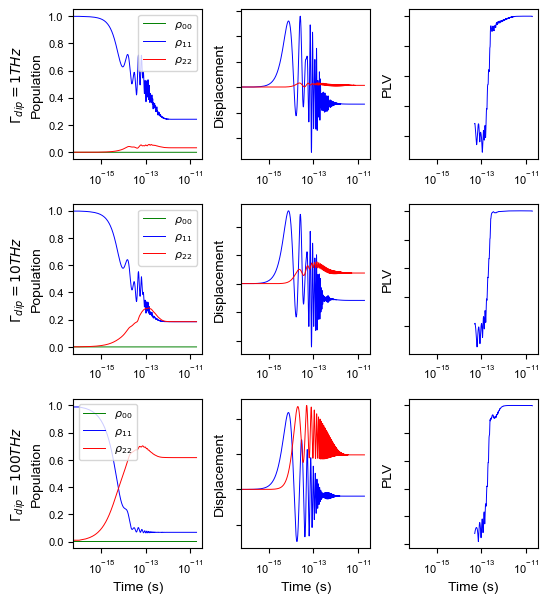

In [13]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.constants as cons
from scipy.signal import hilbert
from matplotlib.gridspec import GridSpec

# ---- Global plot style (Arial, label/tick fontsize=10, legend fontsize=8) ----
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

N = 3  # number of vibrational fock states
hbar = cons.hbar
kB = cons.k
h = cons.h
c = cons.c
ratio = h * c * 100

T = 298  # temperature
beta = 1/(kB * T)
J = 92 * ratio / hbar  # dipole-dipole interaction strength
w1, w2 = 1450 * ratio / hbar, 1111 * ratio / hbar  # vibrational energy quantum
S1, S2 = 0.1013, 0.0578
g1, g2 = -w1 * np.sqrt(S1), -w2 * np.sqrt(S2)  # coupling strength between electronic-vibrational states
De = 1042 * ratio / hbar

Gamma_th = 1e12  # Brownian dissipation rate
Gamma_deph = 1e13  # electronic dephasing rate

# Thermal average bath occupation
def n_ph(w, beta):
    return 1/(np.exp(beta*w)-1)

# Define custom colors
color_green = 'g'
color_blue = 'b'
color_red = 'r'

# Gamma_p values to compare
Gamma_p_values = [1e12, 1e13, 1e14]

# Create figure with 3 rows x 3 columns
fig = plt.figure(figsize=(6, 7))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# Initial state
psi0 = qt.tensor(qt.fock(N, 1), qt.basis(2, 0), qt.fock(N, 0), qt.basis(2, 1))
dm0 = psi0 * psi0.dag()

# Operators
b1 = qt.tensor(qt.destroy(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))
sm1 = qt.tensor(qt.qeye(N), qt.sigmam(), qt.qeye(N), qt.qeye(2))
sx1 = qt.tensor(qt.qeye(N), qt.sigmax(), qt.qeye(N), qt.qeye(2))
sz1 = qt.tensor(qt.qeye(N), qt.sigmaz(), qt.qeye(N), qt.qeye(2))

b2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.destroy(N), qt.qeye(2))
sm2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmam())
sx2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmax())
sz2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmaz())

I = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))

op1 = sm1.dag() * sm1 * (I - sm2.dag() * sm2)
op2 = (I - sm1.dag() * sm1) * sm2.dag() * sm2
op0 = sm1.dag() * sm1 * sm2.dag() * sm2

# Expectation operators
e_op_list = []
e_op_list.append(b1 + b1.dag())
e_op_list.append(b2 + b2.dag())

t_end, t_len = 2e-11, int(2e5)
resol = 1e-13
dt = int(t_len/(t_end/resol))

tlist = np.linspace(0, t_end, t_len+1)

e1, e2, ep = 19574 * ratio / hbar, 18532 * ratio / hbar, 60000 * ratio / hbar
wp = e1 + w1
Omega = 2e14

Hel = e1 * op1 + e2 * op2 + ep * op0
Hvib = w1 * b1.dag() * b1 + w2 * b2.dag() * b2
Vdis = g1 * op1 * (b1 + b1.dag()) + g2 * op2 * (b2 + b2.dag())
Vdip = J * (sm1.dag() * sm2 + sm2.dag() * sm1)

H = Hel + Hvib + Vdis + Vdip

# Simulation arguments
args = {'wp': wp}
# Pumping interaction Hamiltonian (time-dependent part)
Vp_h = (Omega/2) * sm1.dag()

# Time-dependent coefficients for the pumping interaction
def Vp_h_coeff(t, args):
    return np.exp(-1j * args['wp'] * t)

def Vp_c_coeff(t, args):
    return np.exp(1j * args['wp'] * t)

# Time-dependent Hamiltonian
H_new = [H, [Vp_h, Vp_h_coeff], [Vp_h.dag(), Vp_c_coeff]]

# Loop over each Gamma_p value
for row_idx, Gamma_p in enumerate(Gamma_p_values):
    print(f"Running simulation for Gamma_p = {Gamma_p:.0e}")
    
    # Collapse operators
    c_op_list = []
    # Vibron annihilation
    c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w1, beta))) * b1)
    c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w2, beta))) * b2)
    # Vibron creation
    c_op_list.append(np.sqrt(Gamma_th * n_ph(w1, beta)) * b1.dag())
    c_op_list.append(np.sqrt(Gamma_th * n_ph(w2, beta)) * b2.dag())
    # Excitation annihilation
    c_op_list.append(np.sqrt(Gamma_deph) * sm1)
    c_op_list.append(np.sqrt(Gamma_deph) * sm2)
    # Environment-assisted transfer
    c_op_list.append(np.sqrt(Gamma_p) * sm2.dag()*sm1)
    
    # Run simulation
    output = qt.mesolve(H_new, dm0, tlist, c_op_list, e_op_list, args=args,
                        options={'store_states': True})
    
    # Extract populations
    rho_11 = []
    rho_22 = []
    rho_00 = []
    for state in output.states:
        rho = state.ptrace([1, 3]).full()
        rho_11.append(rho[1, 1])
        rho_22.append(rho[2, 2])
        rho_00.append(rho[0, 0])
    
    # Calculate PLV
    phi1 = np.angle(hilbert(np.real(output.expect[0])))
    phi2 = np.angle(hilbert(np.real(output.expect[1])))
    exp_phase = np.exp(1j * (phi1 - phi2))
    PLV = np.abs(np.convolve(exp_phase, np.ones(dt)/dt, mode='valid'))
    t_plv = np.abs(np.convolve(tlist, np.ones(dt)/dt, mode='valid'))
    
    # Create subplots for this row
    ax1 = fig.add_subplot(gs[row_idx, 0])
    ax2 = fig.add_subplot(gs[row_idx, 1])
    ax3 = fig.add_subplot(gs[row_idx, 2], sharex=ax2)
    
    # Set log scale
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax3.set_xscale("log")
    
    # Plot populations
    ax1.plot(tlist, rho_00, c=color_green, label=r"$\rho_{00}$", lw=0.7)
    ax1.plot(tlist, rho_11, c=color_blue, label=r"$\rho_{11}$", lw=0.7)
    ax1.plot(tlist, rho_22, c=color_red, label=r"$\rho_{22}$", lw=0.7)
    
    # Plot displacements
    ax2.plot(tlist, output.expect[0], c=color_blue, label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$", lw=0.7)
    ax2.plot(tlist, output.expect[1], c=color_red, label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$", lw=0.7)
    
    # Plot PLV
    ax3.plot(t_plv[:-dt], PLV[:-dt], label='PLV', lw=0.7, c=color_blue)
    
    # Add labels and legends
    if row_idx == 2:  # Bottom row
        ax1.set_xlabel("Time (s)", fontsize=10)
        ax2.set_xlabel("Time (s)", fontsize=10)
        ax3.set_xlabel("Time (s)", fontsize=10)
    
    ax1.set_ylabel(f"$\Gamma_{{dip}} = {{{int(10**(np.log10(Gamma_p)-12))}}} THz$\nPopulation", fontsize=10)
    ax2.set_ylabel("Displacement", fontsize=10)
    ax3.set_ylabel("PLV", fontsize=10)
    
    ax1.legend(fontsize=8, loc="best")
    # ax2.legend(fontsize=8, loc="best")
    # ax3.legend(fontsize=8, loc="best")
    
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    
    # Enforce Arial font on all elements
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='both', which='both', labelsize=8)
        for lbl in (ax.get_xticklabels() + ax.get_yticklabels()):
            lbl.set_fontname("Arial")
        ax.xaxis.label.set_fontname("Arial")
        ax.yaxis.label.set_fontname("Arial")
        if ax.get_title():
            ax.title.set_fontname("Arial")
        leg = ax.get_legend()
        if leg is not None:
            for text in leg.get_texts():
                text.set_fontname("Arial")

plt.tight_layout()
plt.savefig(
    "G_dip_comparison_gth12.pdf",
    dpi=300,
    bbox_inches='tight',
    transparent=True
)
print("Figure saved as G_dip_comparison.pdf")
plt.show()

Running simulation for Gamma_p = 1e+12


/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/2155691359.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/2155691359.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576:

Running simulation for Gamma_p = 1e+13


/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/2155691359.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*w)-1)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Running simulation for Gamma_p = 1e+14


/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/wenhao/miniconda3/envs/data_sci/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/kv/l8s5zrx50gx0_7w1s48d6p880000gn/T/ipykernel_19580/2155691359.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Figure saved as G_dip_comparison.pdf


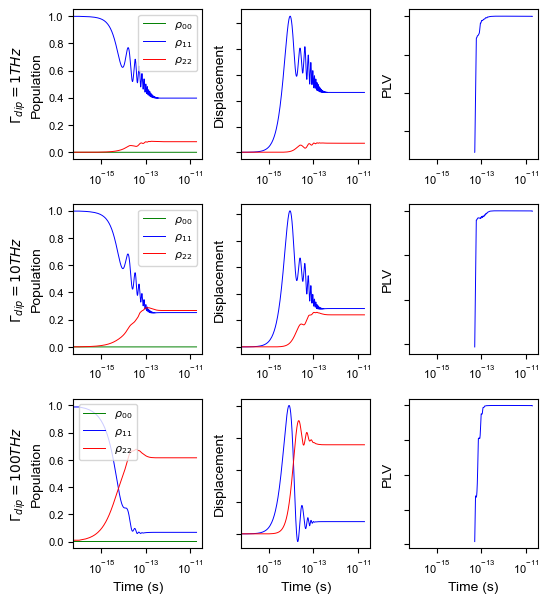

In [14]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.constants as cons
from scipy.signal import hilbert
from matplotlib.gridspec import GridSpec

# ---- Global plot style (Arial, label/tick fontsize=10, legend fontsize=8) ----
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

N = 3  # number of vibrational fock states
hbar = cons.hbar
kB = cons.k
h = cons.h
c = cons.c
ratio = h * c * 100

T = 298  # temperature
beta = 1/(kB * T)
J = 92 * ratio / hbar  # dipole-dipole interaction strength
w1, w2 = 1450 * ratio / hbar, 1111 * ratio / hbar  # vibrational energy quantum
S1, S2 = 0.1013, 0.0578
g1, g2 = -w1 * np.sqrt(S1), -w2 * np.sqrt(S2)  # coupling strength between electronic-vibrational states
De = 1042 * ratio / hbar

Gamma_th = 1e14  # Brownian dissipation rate
Gamma_deph = 1e13  # electronic dephasing rate

# Thermal average bath occupation
def n_ph(w, beta):
    return 1/(np.exp(beta*w)-1)

# Define custom colors
color_green = 'g'
color_blue = 'b'
color_red = 'r'

# Gamma_p values to compare
Gamma_p_values = [1e12, 1e13, 1e14]

# Create figure with 3 rows x 3 columns
fig = plt.figure(figsize=(6, 7))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# Initial state
psi0 = qt.tensor(qt.fock(N, 1), qt.basis(2, 0), qt.fock(N, 0), qt.basis(2, 1))
dm0 = psi0 * psi0.dag()

# Operators
b1 = qt.tensor(qt.destroy(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))
sm1 = qt.tensor(qt.qeye(N), qt.sigmam(), qt.qeye(N), qt.qeye(2))
sx1 = qt.tensor(qt.qeye(N), qt.sigmax(), qt.qeye(N), qt.qeye(2))
sz1 = qt.tensor(qt.qeye(N), qt.sigmaz(), qt.qeye(N), qt.qeye(2))

b2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.destroy(N), qt.qeye(2))
sm2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmam())
sx2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmax())
sz2 = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.sigmaz())

I = qt.tensor(qt.qeye(N), qt.qeye(2), qt.qeye(N), qt.qeye(2))

op1 = sm1.dag() * sm1 * (I - sm2.dag() * sm2)
op2 = (I - sm1.dag() * sm1) * sm2.dag() * sm2
op0 = sm1.dag() * sm1 * sm2.dag() * sm2

# Expectation operators
e_op_list = []
e_op_list.append(b1 + b1.dag())
e_op_list.append(b2 + b2.dag())

t_end, t_len = 2e-11, int(2e5)
resol = 1e-13
dt = int(t_len/(t_end/resol))

tlist = np.linspace(0, t_end, t_len+1)

e1, e2, ep = 19574 * ratio / hbar, 18532 * ratio / hbar, 60000 * ratio / hbar
wp = e1 + w1
Omega = 2e14

Hel = e1 * op1 + e2 * op2 + ep * op0
Hvib = w1 * b1.dag() * b1 + w2 * b2.dag() * b2
Vdis = g1 * op1 * (b1 + b1.dag()) + g2 * op2 * (b2 + b2.dag())
Vdip = J * (sm1.dag() * sm2 + sm2.dag() * sm1)

H = Hel + Hvib + Vdis + Vdip

# Simulation arguments
args = {'wp': wp}
# Pumping interaction Hamiltonian (time-dependent part)
Vp_h = (Omega/2) * sm1.dag()

# Time-dependent coefficients for the pumping interaction
def Vp_h_coeff(t, args):
    return np.exp(-1j * args['wp'] * t)

def Vp_c_coeff(t, args):
    return np.exp(1j * args['wp'] * t)

# Time-dependent Hamiltonian
H_new = [H, [Vp_h, Vp_h_coeff], [Vp_h.dag(), Vp_c_coeff]]

# Loop over each Gamma_p value
for row_idx, Gamma_p in enumerate(Gamma_p_values):
    print(f"Running simulation for Gamma_p = {Gamma_p:.0e}")
    
    # Collapse operators
    c_op_list = []
    # Vibron annihilation
    c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w1, beta))) * b1)
    c_op_list.append(np.sqrt(Gamma_th * (1 + n_ph(w2, beta))) * b2)
    # Vibron creation
    c_op_list.append(np.sqrt(Gamma_th * n_ph(w1, beta)) * b1.dag())
    c_op_list.append(np.sqrt(Gamma_th * n_ph(w2, beta)) * b2.dag())
    # Excitation annihilation
    c_op_list.append(np.sqrt(Gamma_deph) * sm1)
    c_op_list.append(np.sqrt(Gamma_deph) * sm2)
    # Environment-assisted transfer
    c_op_list.append(np.sqrt(Gamma_p) * sm2.dag()*sm1)
    
    # Run simulation
    output = qt.mesolve(H_new, dm0, tlist, c_op_list, e_op_list, args=args,
                        options={'store_states': True})
    
    # Extract populations
    rho_11 = []
    rho_22 = []
    rho_00 = []
    for state in output.states:
        rho = state.ptrace([1, 3]).full()
        rho_11.append(rho[1, 1])
        rho_22.append(rho[2, 2])
        rho_00.append(rho[0, 0])
    
    # Calculate PLV
    phi1 = np.angle(hilbert(np.real(output.expect[0])))
    phi2 = np.angle(hilbert(np.real(output.expect[1])))
    exp_phase = np.exp(1j * (phi1 - phi2))
    PLV = np.abs(np.convolve(exp_phase, np.ones(dt)/dt, mode='valid'))
    t_plv = np.abs(np.convolve(tlist, np.ones(dt)/dt, mode='valid'))
    
    # Create subplots for this row
    ax1 = fig.add_subplot(gs[row_idx, 0])
    ax2 = fig.add_subplot(gs[row_idx, 1])
    ax3 = fig.add_subplot(gs[row_idx, 2], sharex=ax2)
    
    # Set log scale
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax3.set_xscale("log")
    
    # Plot populations
    ax1.plot(tlist, rho_00, c=color_green, label=r"$\rho_{00}$", lw=0.7)
    ax1.plot(tlist, rho_11, c=color_blue, label=r"$\rho_{11}$", lw=0.7)
    ax1.plot(tlist, rho_22, c=color_red, label=r"$\rho_{22}$", lw=0.7)
    
    # Plot displacements
    ax2.plot(tlist, output.expect[0], c=color_blue, label=r"$\langle\hat{b}_1^{\dagger}+\hat{b}_1\rangle$", lw=0.7)
    ax2.plot(tlist, output.expect[1], c=color_red, label=r"$\langle\hat{b}_2^{\dagger}+\hat{b}_2\rangle$", lw=0.7)
    
    # Plot PLV
    ax3.plot(t_plv[:-dt], PLV[:-dt], label='PLV', lw=0.7, c=color_blue)
    
    # Add labels and legends
    if row_idx == 2:  # Bottom row
        ax1.set_xlabel("Time (s)", fontsize=10)
        ax2.set_xlabel("Time (s)", fontsize=10)
        ax3.set_xlabel("Time (s)", fontsize=10)
    
    ax1.set_ylabel(f"$\Gamma_{{dip}} = {{{int(10**(np.log10(Gamma_p)-12))}}} THz$\nPopulation", fontsize=10)
    ax2.set_ylabel("Displacement", fontsize=10)
    ax3.set_ylabel("PLV", fontsize=10)
    
    ax1.legend(fontsize=8, loc="best")
    # ax2.legend(fontsize=8, loc="best")
    # ax3.legend(fontsize=8, loc="best")
    
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    
    # Enforce Arial font on all elements
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='both', which='both', labelsize=8)
        for lbl in (ax.get_xticklabels() + ax.get_yticklabels()):
            lbl.set_fontname("Arial")
        ax.xaxis.label.set_fontname("Arial")
        ax.yaxis.label.set_fontname("Arial")
        if ax.get_title():
            ax.title.set_fontname("Arial")
        leg = ax.get_legend()
        if leg is not None:
            for text in leg.get_texts():
                text.set_fontname("Arial")

plt.tight_layout()
plt.savefig(
    "G_dip_comparison_gth14.pdf",
    dpi=300,
    bbox_inches='tight',
    transparent=True
)
print("Figure saved as G_dip_comparison.pdf")
plt.show()